In [1]:
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import pickle
import os
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


##Loading Flikr8k Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_folder = '/content/drive/MyDrive/Flickr8k/'

In [4]:
images_folder = data_folder + 'Flicker8k_Dataset/'
captions_file = data_folder + 'Flickr8k.token.txt'


In [5]:
# loading the captions file into a DataFrame
captions_data = pd.read_csv(captions_file, delimiter='\t', header=None)
captions_data.columns = ['image', 'caption']

In [6]:
captions_data.head()

,image,caption
0,1000268201_693b08cb0e.jpg#0,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg#1,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg#2,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg#3,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg#4,A little girl in a pink dress going into a woo...


##Pretrained model VGG16

In [17]:
# using vgg16 as a pretrained model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Feature Extraction


In [18]:
# extract features from image
features = {}
directory = images_folder

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)                                                 # converting image pixels to numpy array
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))  # reshape data for model
    # preprocessing image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8106 [00:00<?, ?it/s]

In [20]:
# store features in pickle
import pickle
pickle.dump(features, open(os.path.join(data_folder, 'features.pkl'), 'wb'))

In [8]:
# load features from pickle
with open(os.path.join(data_folder, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [9]:
captions_doc = captions_data.to_numpy()

In [10]:
captions_doc[0]

array(['1000268201_693b08cb0e.jpg#0',
       'A child in a pink dress is climbing up a set of stairs in an entry way .'],
      dtype=object)

In [11]:
# creating mapping of image to captions
mapping = {}
lines = captions_doc.shape[0]
for i in range(lines):
    image_id, caption = captions_doc[i][0], captions_doc[i][1]
    image_id = image_id.split('.')[0]                   # remove extension from image ID
    caption = "".join(caption)                         # convert caption list to string
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)


In [12]:
len(mapping)

8092

##Preprocessing Caption Data


In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()                            # convert to lowercase
            caption = caption.replace('[^A-Za-z]', '')           # delete digits, special chars, etc.,
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [14]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [15]:
clean(mapping)

In [16]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [17]:
mapping['2258277193_586949ec62']

['startseq people waiting for the subway endseq',
 'startseq some people looking out windows in large building endseq',
 'startseq three people are waiting on train platform endseq',
 'startseq three people standing at station endseq',
 'startseq two woman and one man standing near train tracks endseq']

In [18]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
len(all_captions)

40460

In [20]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [21]:
# tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

In [22]:
print(vocab_size,",",max_length)

8485 , 34


##Train-Test Split


In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
len(image_ids)

8092

In [25]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            n += 1
            if(key == '2258277193_586949ec62'):
              continue
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]  # Pad input sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1 = np.array(X1)
                X2 = np.array(X2)
                y = np.array(y)
                yield [X1, X2] , y
                X1, X2, y = [], [], []
                n = 0


##Model Architecture

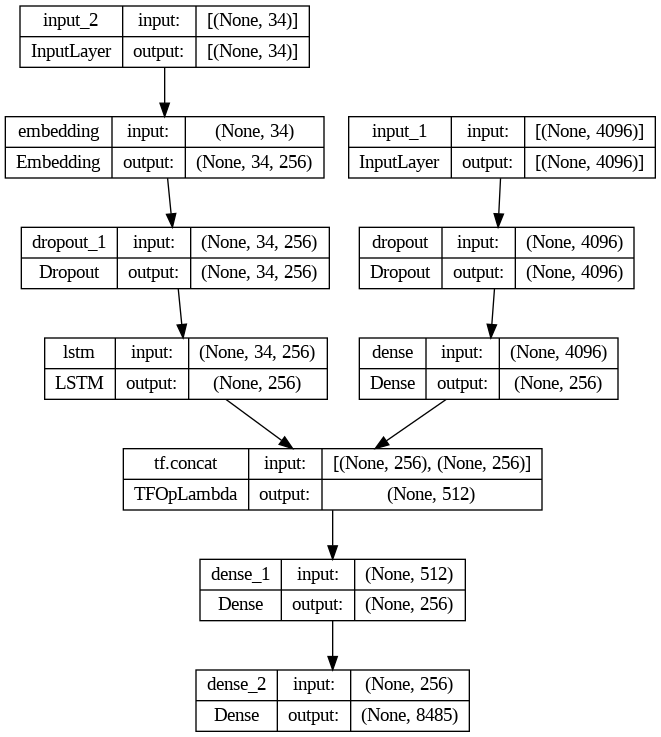

In [26]:
import tensorflow as tf
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = tf.concat([fe2, se3], 1)
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

## Training

In [27]:
# train the model

epochs = 10
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 54s 476ms/step - loss: 2.7213


In [28]:
model.save(data_folder + '/imgcap_model.h5')

##Caption Generation

In [29]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [30]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [31]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.579200
BLEU-4: 0.143645


###Results

In [32]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(images_folder, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq crowd of people is standing around red white and blue hot air balloon as it is readied to launch into the blue sky endseq
startseq crowd of people watch as remax hot air balloon gets ready to take off endseq
startseq hot air balloon just off the ground surrounded by people endseq
startseq red hot air balloon lands in field among crowd endseq
startseq people next to red white and blue hot air balloon that is on the grass endseq
--------------------Predicted--------------------
startseq plane balloon in front of rainbow balloon endseq


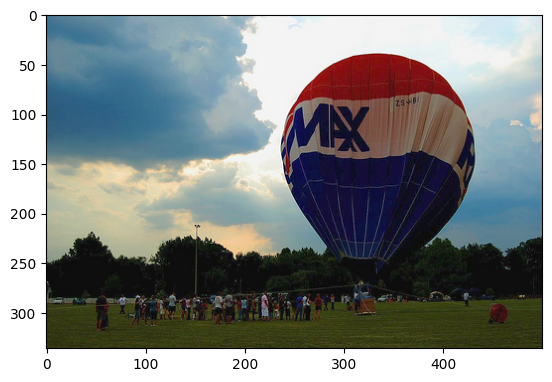

In [33]:
generate_caption("2369452202_8b0e8e25ca.jpg")

---------------------Actual---------------------
startseq little dog chases chihuahua endseq
startseq dogs enjoy chasing each other in the park endseq
startseq some dogs running through the park endseq
startseq two dogs are running around in fenced in area endseq
startseq two dogs run through field endseq
--------------------Predicted--------------------
startseq dog is running through the air endseq


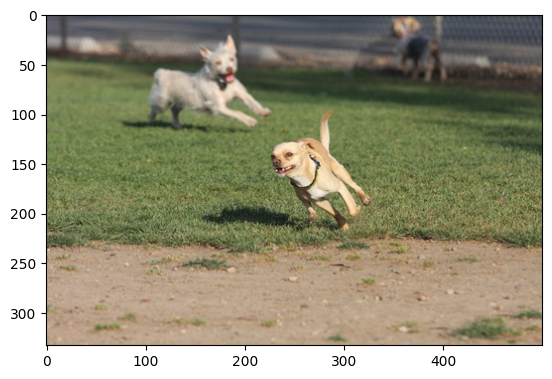

In [34]:
generate_caption("3532098999_4e07a0a17e.jpg")

---------------------Actual---------------------
startseq child in black wetsuit is in the waves on surfboard endseq
startseq kid on surfboard riding small wave endseq
startseq small boy in black is surfing endseq
startseq young boy in black wetsuit surfs in the water endseq
startseq young surfer rides wave endseq
--------------------Predicted--------------------
startseq surfer is riding wave in the ocean endseq


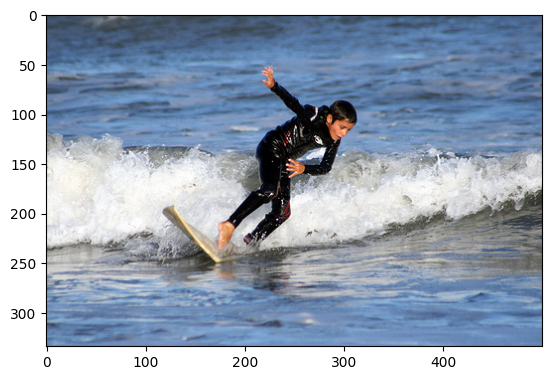

In [36]:
generate_caption("2258662398_2797d0eca8.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl in yellow dress is sitting in front of rainbow rainbow rainbow rainbow rainbow rainbow endseq


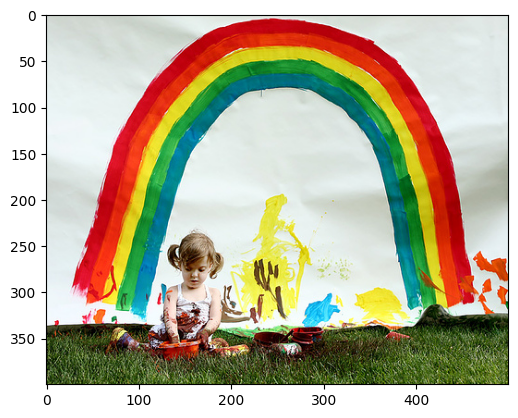

In [37]:
generate_caption("1002674143_1b742ab4b8.jpg")